In [55]:
#Imports
# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import tensorflow as tf 
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# import numpy as np
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [56]:

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')



# Load training and validation sets
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 2000 files belonging to 2 classes.
Found 1909 files belonging to 2 classes.


Load Pretrained Base

In [45]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[128,128,3],
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
pretrained_base.trainable = False

Early Stopping

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Attach Head

In [58]:




# Pretrained base model

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])

# Custom base  0.720796 val_binary_accuracy

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    layers.Dropout(0.1),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 128)     

Train

In [59]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping], 
    verbose=1,
)

Epoch 1/50
24/32 [=====================>........] - ETA: 8s - loss: 0.6926 - binary_accuracy: 0.5625

KeyboardInterrupt: 

0     0.601886
1     0.640126
2     0.651650
3     0.685175
4     0.717653
5     0.721844
6     0.738083
7     0.760084
8     0.757988
9     0.739654
10    0.779466
11    0.782085
12    0.733892
13    0.783656
14    0.804086
15    0.809848
16    0.822420
17    0.796228
18    0.810372
19    0.775275
20    0.803038
21    0.811943
Name: val_binary_accuracy, dtype: float64


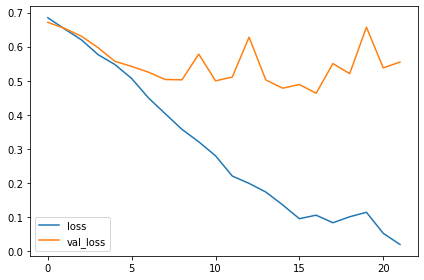

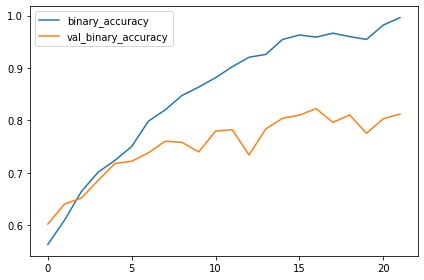

In [51]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print(history_frame.val_binary_accuracy)
